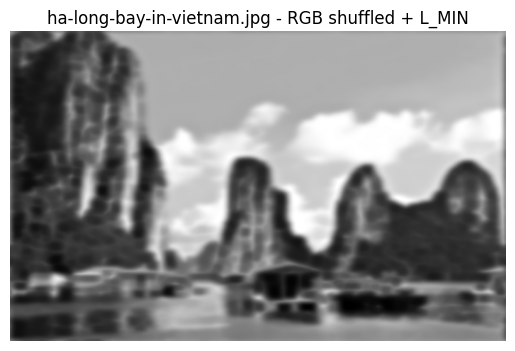

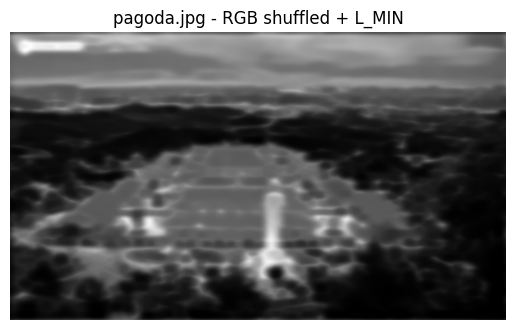

C:\Users\TUF\AppData\Local\Temp\ipykernel_9788\813763754.py:44: RuntimeWarning: divide by zero encountered in divide
  H = 1 / (1 + (cutoff / D)**(2*order))


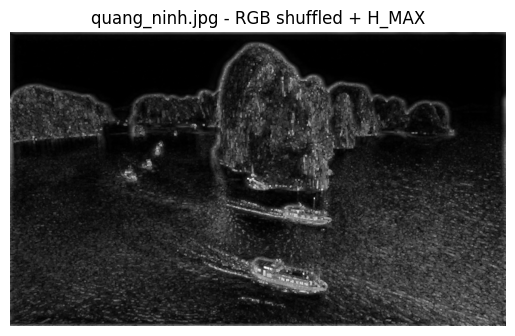

In [ ]:
# Câu 4:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as iio
from PIL import Image
import math
import os
import random
from scipy.fft import fft2, fftshift, ifft2

# Thư mục chứa ảnh
folder = "exercise"
output_folder = "output_cau4"
os.makedirs(output_folder, exist_ok=True)

def fast_fourier_transform(img):
    f = fft2(img)
    fshift = fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return magnitude_spectrum.astype(np.uint8)

def butterworth_lowpass(img, cutoff=30, order=2):
    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(u - crow, v - ccol, indexing='ij')
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (D / cutoff)**(2*order))
    
    F = fft2(img)
    F_shift = fftshift(F)
    G = F_shift * H
    img_back = np.abs(ifft2(np.fft.ifftshift(G)))
    return np.clip(img_back, 0, 255).astype(np.uint8)

def butterworth_highpass(img, cutoff=30, order=2):
    rows, cols = img.shape
    crow, ccol = rows // 2 , cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(u - crow, v - ccol, indexing='ij')
    D = np.sqrt(U**2 + V**2)
    H = 1 / (1 + (cutoff / D)**(2*order))
    H[D == 0] = 0

    F = fft2(img)
    F_shift = fftshift(F)
    G = F_shift * H
    img_back = np.abs(ifft2(np.fft.ifftshift(G)))
    return np.clip(img_back, 0, 255).astype(np.uint8)

def min_filter(img, size=3):
    pad = size // 2
    padded = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+size, j:j+size]
            result[i, j] = np.min(region)
    return result

def max_filter(img, size=3):
    pad = size // 2
    padded = np.pad(img, pad, mode='edge')
    result = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded[i:i+size, j:j+size]
            result[i, j] = np.max(region)
    return result

transformations = [
    ('F', fast_fourier_transform),
    ('L', butterworth_lowpass),
    ('H', butterworth_highpass)
]

def list_images(folder):
    images = []
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.png')):
            images.append(f"{folder}/{file}")
    return images

filenames = list_images(folder)
for path in filenames:
    filename = path.split("/")[-1]
    img = Image.open(path).convert('RGB')
    img_np = np.array(img)

    # Hoán vị RGB ngẫu nhiên
    channels = [0, 1, 2]
    random.shuffle(channels)
    img_shuffled = img_np[:, :, channels]

    # Chuyển sang grayscale để biến đổi
    img_gray = Image.fromarray(img_shuffled).convert('L')
    img_gray_np = np.array(img_gray)

    label, func = random.choice(transformations)
    transformed = func(img_gray_np)

    # Bổ sung Min/Max Filter nếu là Butterworth
    if label == 'L':
        transformed = min_filter(transformed)
        label += '_MIN'
    elif label == 'H':
        transformed = max_filter(transformed)
        label += '_MAX'

    plt.imshow(transformed, cmap='gray')
    plt.title(f"{filename} - RGB shuffled + {label}")
    plt.axis('off')
    plt.show()

    out_path = f"{output_folder}/{filename.split('.')[0]}_RGB_{label}.png"
    iio.imwrite(out_path, transformed)
